In [1]:
# Install requirements
!pip install --quiet "lightning" "torchmetrics" "decord" "dahuffman" "pytorch_msssim" "scikit-video"

In [2]:
# Pull source code
!git clone https://github.com/minhngt62/vtl-video-compression.git

Cloning into 'vtl-video-compression'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 312 (delta 60), reused 68 (delta 28), pack-reused 209
Receiving objects: 100% (312/312), 65.04 MiB | 20.44 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [3]:
# Common import
import os
import math
import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
import torchvision.transforms as T
from lightning.pytorch.loggers import TensorBoardLogger

# Setting the seed
L.seed_everything(42)

# Load videos
import decord as de
ctx = de.cpu(0)
de.bridge.set_bridge("torch")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# Change working directory
%cd "vtl-video-compression"

/kaggle/working/vtl-video-compression


# Dataset

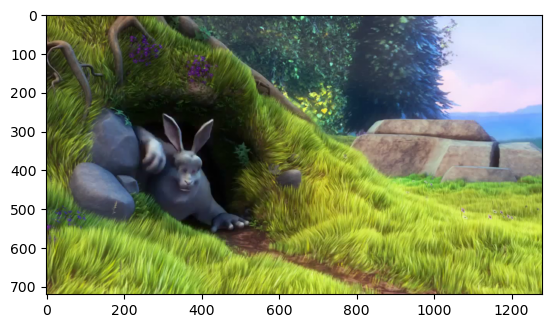

In [5]:
# Build dataset
from video_compression.dataset import BigBuckBunny
bunny_set = BigBuckBunny()
_, frame = next(iter(bunny_set))
plt.imshow(frame.permute(1, 2, 0).numpy())

# Compression

In [6]:
# Load the model
from video_compression.setup import LtNerv
from video_compression.setup.train_test import test
nervl = LtNerv(fc_hw_dim="9_16_112") # NeRV-L
nervm = LtNerv(fc_hw_dim="9_16_58") # NeRV-M
nervs = LtNerv(fc_hw_dim="9_16_26") # NeRV-S

In [7]:
# Benchmark NeRV-L
ckpt_path = "/kaggle/input/nerv-checkpoints/nervl-epoch149-step19800.ckpt"
test(nervl, bunny_set, weights=ckpt_path)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_msssim': 0.9890729784965515,
  'test_psnr': 37.41419982910156,
  'test_fps': 194.9088897705078}]

In [8]:
# Benchmark NeRV-M
ckpt_path = "/kaggle/input/nerv-checkpoints/nervm-epoch149-step19800.ckpt"
test(nervm, bunny_set, weights=ckpt_path)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_msssim': 0.9760003685951233,
  'test_psnr': 34.133174896240234,
  'test_fps': 194.43011474609375}]

In [9]:
# Benchmark NeRV-S
ckpt_path = "/kaggle/input/nerv-checkpoints/nervs-epoch149-step19800.ckpt"
test(nervs, bunny_set, weights=ckpt_path)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_msssim': 0.936585545539856,
  'test_psnr': 30.105751037597656,
  'test_fps': 204.53021240234375}]

# Reconstruction

In [8]:
# Load the model
from video_compression.setup import LtNerv
from video_compression.setup.train_test import test
nervl = LtNerv(fc_hw_dim="9_16_112") # NeRV-L
nervm = LtNerv(fc_hw_dim="9_16_58") # NeRV-M
nervs = LtNerv(fc_hw_dim="9_16_26") # NeRV-S

# Setup the loader
bunny_loader = data.DataLoader(bunny_set, batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=False,)

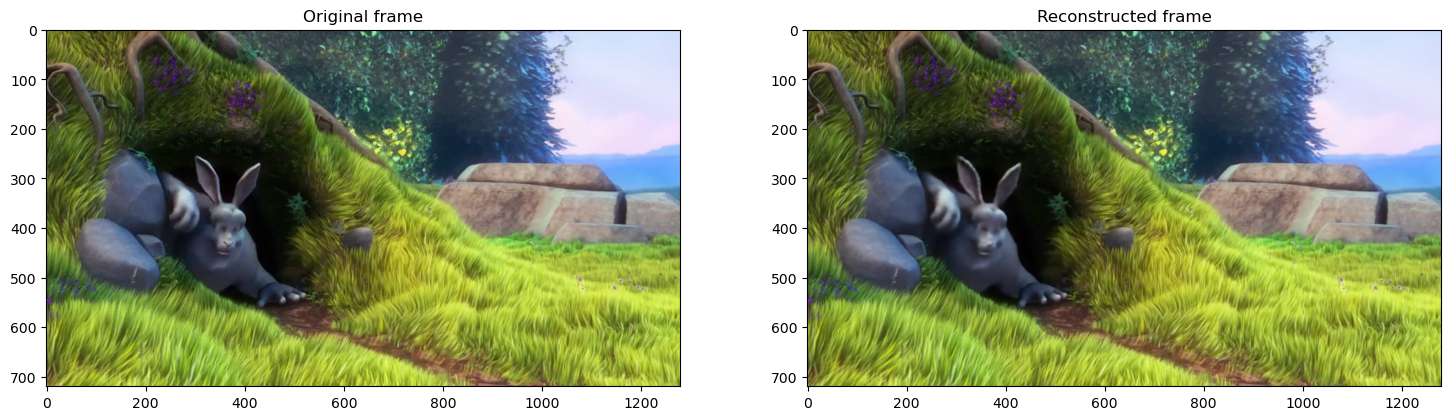

In [19]:
# Benchmark NeRV-L
ckpt_path = "/kaggle/input/nerv-checkpoints/nervl-epoch149-step19800.ckpt"
nervl = nervl.load_from_checkpoint(ckpt_path)

with torch.no_grad():
    fig, axs = plt.subplots(1, 2, figsize=(18, 12))
    for frame_inds, frames in bunny_loader:
        recon_frames = nervl(frame_inds)
        axs[0].imshow(frames[0].permute(1, 2, 0))
        axs[0].title.set_text("Original frame")
        axs[1].imshow(recon_frames[0][0].permute(1, 2, 0))
        axs[1].title.set_text("Reconstructed frame")
        break

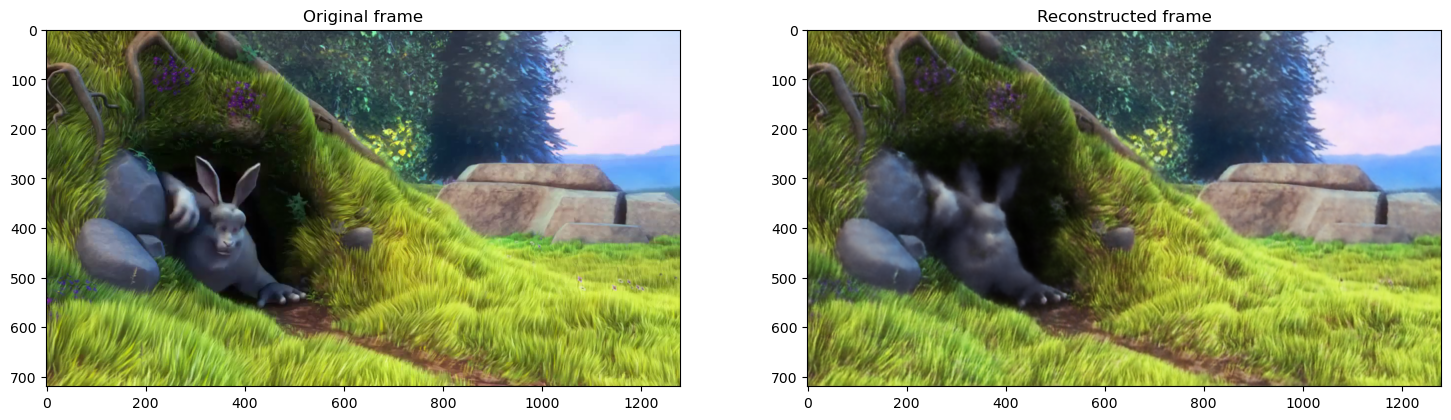

In [18]:
# Benchmark NeRV-S
ckpt_path = "/kaggle/input/nerv-checkpoints/nervs-epoch149-step19800.ckpt"
nervs = nervs.load_from_checkpoint(ckpt_path)

with torch.no_grad():
    fig, axs = plt.subplots(1, 2, figsize=(18, 12))
    for frame_inds, frames in bunny_loader:
        recon_frames = nervs(frame_inds)
        axs[0].imshow(frames[0].permute(1, 2, 0))
        axs[0].title.set_text("Original frame")
        axs[1].imshow(recon_frames[0][0].permute(1, 2, 0))
        axs[1].title.set_text("Reconstructed frame")
        break

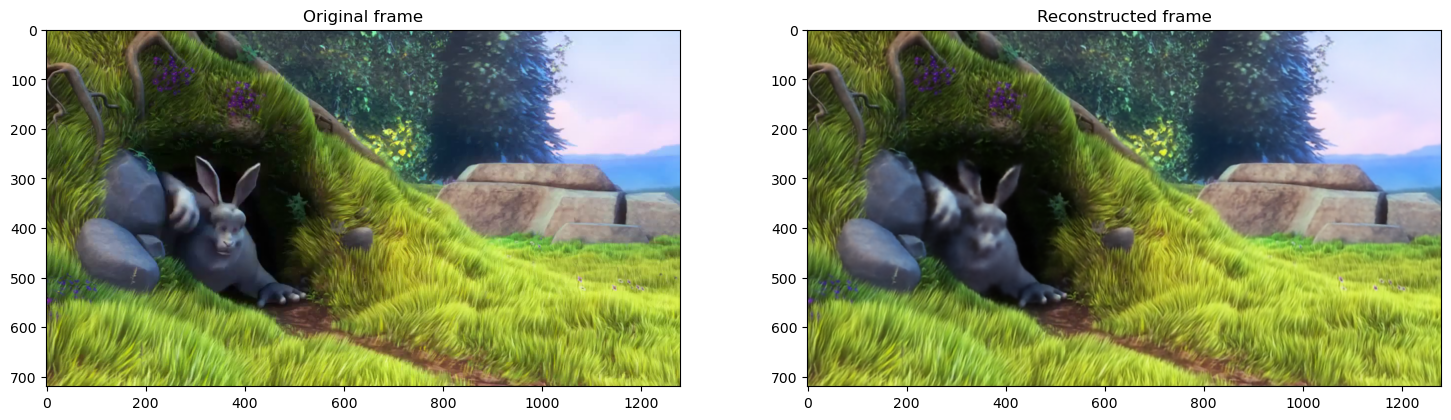

In [17]:
# Benchmark NeRV-M
ckpt_path = "/kaggle/input/nerv-checkpoints/nervm-epoch149-step19800.ckpt"
nervm = nervm.load_from_checkpoint(ckpt_path)

with torch.no_grad():
    fig, axs = plt.subplots(1, 2, figsize=(18, 12))
    for frame_inds, frames in bunny_loader:
        recon_frames = nervm(frame_inds)
        axs[0].imshow(frames[0].permute(1, 2, 0))
        axs[0].title.set_text("Original frame")
        axs[1].imshow(recon_frames[0][0].permute(1, 2, 0))
        axs[1].title.set_text("Reconstructed frame")
        break